In [1]:
from dotenv import load_dotenv
import torch
import sys
import os


load_dotenv()  # will load from .env file in the same directory

# Then add this to check the environment:

print(f"CUDA_HOME: {os.environ.get('CUDA_HOME', 'Not set')}")


def check_cuda():
    print(f"PyTorch version: {torch.__version__}")
    print(f"Python version: {sys.version}")

    # Check if CUDA is available
    cuda_available = torch.cuda.is_available()
    print(f"\nCUDA available: {cuda_available}")

    if cuda_available:
        # Get current CUDA device
        current_device = torch.cuda.current_device()
        # Get device properties
        device_props = torch.cuda.get_device_properties(current_device)

        print("\nCUDA Device Details:")
        print(f"  Device: {torch.cuda.get_device_name(current_device)}")
        print(f"  Total memory: {device_props.total_memory / 1024**3:.2f} GB")
        print(f"  CUDA capability: {device_props.major}.{device_props.minor}")
        print(f"  Number of CUDA devices: {torch.cuda.device_count()}")
    else:
        print("\nNo CUDA devices available")


check_cuda()

CUDA_HOME: /run/current-system/sw
PyTorch version: 2.6.0+cu124
Python version: 3.12.9 (main, Feb 12 2025, 14:50:50) [Clang 19.1.6 ]

CUDA available: True

CUDA Device Details:
  Device: NVIDIA GeForce RTX 4060 Ti
  Total memory: 15.60 GB
  CUDA capability: 8.9
  Number of CUDA devices: 1


In [ ]:
# Load model
# model can be downloaded from https://huggingface.co/lingxusb/megaDNA_updated/resolve/main/megaDNA_phage_145M.pt
model_path = "../checkpoints/megaDNA_phage_145M.pt"  # model name
device = "cuda"  # change this to 'cuda' if you use GPU

model = torch.load(model_path, map_location=torch.device(device), weights_only=False)

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import random

In [6]:
# Load dataset
fasta_file_path = "../dataset/1Jan2025_genomes.fa"
sequences = list(SeqIO.parse(fasta_file_path, "fasta"))

In [11]:
# Create subset with length less than 131072, randomly sample 1000
seq_subset = [seq for seq in sequences if len(str(seq.seq)) < 131072]
seq_subset = random.sample(seq_subset, 1000)

In [13]:
# save the subset
with open("../dataset/1Jan2025_genomes_subset.fa", "w") as f:
    for seq in seq_subset:
        f.write(f">{seq.description}\n{str(seq.seq)}\n")

In [4]:
# load the subset
seq_subset = list(SeqIO.parse("../dataset/1Jan2025_genomes_subset.fa", "fasta"))

In [5]:
def get_embeddings(sequence, model, device, max_seq_length=131072):
    """Get embeddings for a single sequence
    Args:
        sequence: Input DNA sequence
        model: MEGADNA model
        device: torch device (CPU/GPU)
        max_seq_length: Maximum sequence length (default: 131072 from model dimensions 128*64*16)
    Returns:
        combined_emb: 964-dimensional embedding vector (on GPU)
    """
    # Check sequence length
    if len(sequence) > max_seq_length:
        print(f"Warning: Sequence length {len(sequence)} exceeds max length {max_seq_length}")
        sequence = sequence[:max_seq_length]

    # Encode sequence
    nt_vocab = ["**", "A", "T", "C", "G", "#"]
    encoded = [0]  # Start token
    for nucleotide in str(sequence):
        if nucleotide in nt_vocab:
            encoded.append(nt_vocab.index(nucleotide))
        else:
            encoded.append(1)
    encoded.append(5)  # End token

    input_seq = torch.tensor(encoded).unsqueeze(0).to(device)

    with torch.no_grad():
        embeddings = model(input_seq, return_value="embedding")
        local_emb = torch.mean(embeddings[0].squeeze(), dim=0)  # (512,)
        middle_emb = torch.mean(torch.mean(embeddings[1].squeeze(), dim=0), dim=0)  # (256,)
        global_emb = torch.mean(torch.mean(embeddings[2].squeeze(), dim=0), dim=0)  # (196,)
        combined_emb = torch.cat([local_emb, middle_emb, global_emb])  # (964,)

    return combined_emb


def process_sequences(sequences, model, device, batch_size=50, max_seq_length=131072):
    """Process multiple sequences in batches
    Args:
        sequences: List of sequences to process
        model: MEGADNA model
        device: torch device (CPU/GPU)
        batch_size: Number of sequences to process at once
        max_seq_length: Maximum sequence length (default: 131072 from model dimensions 128*64*16)
    Returns:
        all_embeddings: Tensor of shape (n_sequences, 964) containing embeddings
    """
    all_embeddings = torch.zeros((len(sequences), 964), device=device)

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i : i + batch_size]

        for j, record in enumerate(batch):
            try:
                all_embeddings[i + j] = get_embeddings(record.seq, model, device, max_seq_length)
            except Exception as e:
                print(f"Error processing sequence {record.id}: {str(e)}")

        print(f"Processed {min(i + batch_size, len(sequences))}/{len(sequences)} sequences")

    return all_embeddings

In [6]:
# Process all sequences
embeddings = process_sequences(
    sequences=seq_subset, model=model, device=device, batch_size=50, max_seq_length=131072
)

print("\nFinal embeddings shape:", embeddings.shape)  # Should be (number of sequences, 964)

# Save embeddings and sequence information
embeddings_np = embeddings.cpu().numpy()
headers = [record.description for record in seq_subset]
np.save("../results/embeddings.npy", embeddings_np)
np.save("../results/headers.npy", np.array(headers))

print("\nEmbeddings and headers saved to results directory")

/home/spica/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Processed 50/1000 sequences
Processed 100/1000 sequences
Processed 150/1000 sequences
Processed 200/1000 sequences
Processed 250/1000 sequences
Processed 300/1000 sequences
Processed 350/1000 sequences
Processed 400/1000 sequences
Processed 450/1000 sequences
Processed 500/1000 sequences
Processed 550/1000 sequences
Processed 600/1000 sequences
Processed 650/1000 sequences
Processed 700/1000 sequences
Processed 750/1000 sequences
Processed 800/1000 sequences
Processed 850/1000 sequences
Processed 900/1000 sequences
Processed 950/1000 sequences
Processed 1000/1000 sequences

Final embeddings shape: torch.Size([1000, 964])

Embeddings and headers saved to results directory


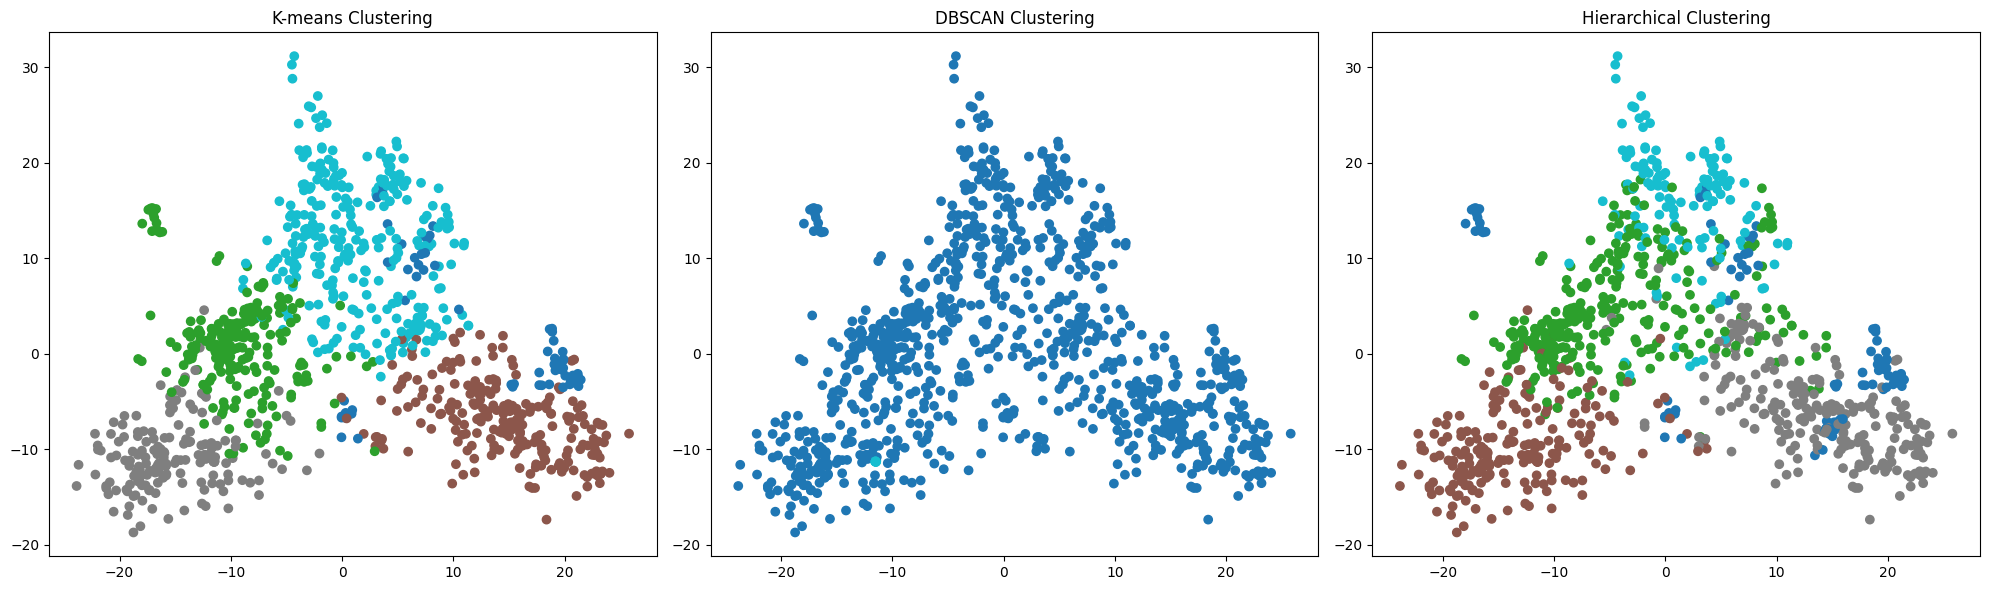


K-means clusters: [ 68 229 240 175 288]
DBSCAN clusters: [988  12]
Hierarchical clusters: [101 314 221 233 131]


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt

# Load and preprocess data
embeddings = np.load("../results/embeddings.npy")
headers = np.load("../results/headers.npy")

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_scaled)

# Try different clustering methods
n_clusters = 5

# 1. K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(embeddings_scaled)

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(embeddings_scaled)

# 3. Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_clusters = hierarchical.fit_predict(embeddings_scaled)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-means plot
axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=kmeans_clusters, cmap="tab10")
axes[0].set_title("K-means Clustering")

# DBSCAN plot
axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dbscan_clusters, cmap="tab10")
axes[1].set_title("DBSCAN Clustering")

# Hierarchical plot
axes[2].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=hierarchical_clusters, cmap="tab10")
axes[2].set_title("Hierarchical Clustering")

plt.tight_layout()
plt.show()

# Print statistics for each method
print("\nK-means clusters:", np.unique(kmeans_clusters, return_counts=True)[1])
print("DBSCAN clusters:", np.unique(dbscan_clusters, return_counts=True)[1])
print("Hierarchical clusters:", np.unique(hierarchical_clusters, return_counts=True)[1])


Host distribution in clusters:

Cluster 0:
host
Mycobacterium        25
Propionibacterium     8
Escherichia           7
Klebsiella            7
Unknown               4
Name: count, dtype: int64

Cluster 1:
host
Streptococcus     41
Unknown           36
Staphylococcus    23
Lactococcus       20
Bacillus          14
Name: count, dtype: int64

Cluster 2:
host
Mycobacterium     67
Gordonia          30
Microbacterium    28
Arthrobacter      22
Pseudomonas       18
Name: count, dtype: int64

Cluster 3:
host
Unknown           139
Enterobacteria     20
Vibrio              7
Coli                3
Spiroplasma         2
Name: count, dtype: int64

Cluster 4:
host
Salmonella     51
Escherichia    42
Pseudomonas    34
Klebsiella     27
Vibrio         24
Name: count, dtype: int64


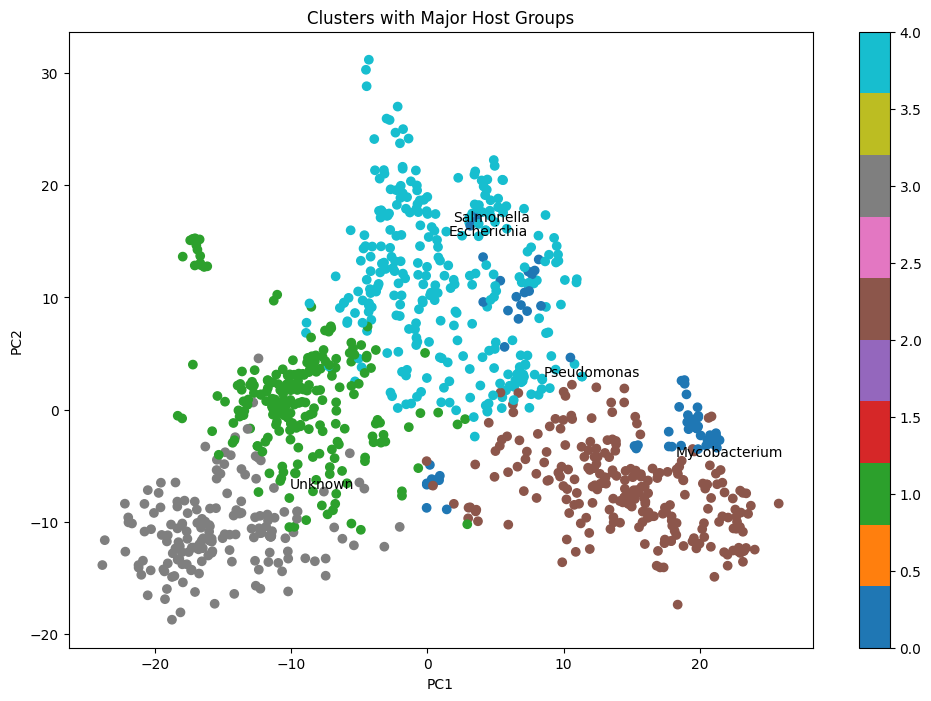

In [17]:
# Create a dataframe with clusters and taxonomy
df = pd.DataFrame({"header": headers, "kmeans_cluster": kmeans_clusters})


# Extract basic taxonomy information
def extract_taxonomy(header):
    # Split at first comma
    info = header.split(",")[0]
    # Get phage/virus name
    if "phage" in info:
        return info.split("phage")[1].strip()
    elif "virus" in info:
        return info.split("virus")[1].strip()
    else:
        return "Unknown"


# Extract host information
def extract_host(header):
    # Get the genus name before 'phage' if it exists
    if "phage" in header:
        before_phage = header.split("phage")[0]
        genus = before_phage.split()[-1]
        return genus
    return "Unknown"


df["phage_name"] = df["header"].apply(extract_taxonomy)
df["host"] = df["header"].apply(extract_host)

# Analyze clusters
print("\nHost distribution in clusters:")
for cluster in range(5):
    print(f"\nCluster {cluster}:")
    print(df[df["kmeans_cluster"] == cluster]["host"].value_counts().head())

# Visualize with same PCA plot but color by host
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=kmeans_clusters, cmap="tab10")
plt.title("Clusters with Major Host Groups")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Add host labels for some major groups
for host in df["host"].value_counts().head().index:
    mask = df["host"] == host
    if sum(mask) > 10:  # Only label if there are enough samples
        center = embeddings_2d[mask].mean(axis=0)
        plt.annotate(host, center, xytext=(10, 10), textcoords="offset points")

plt.colorbar(scatter)
plt.show()